# Capstone Project Progress Report

## Project objective

The objective of this project is to complement traditional retail property data with transport and social media data to offer a more robust and accurate means of predicting retail rental prices.

NYC yellow cab dropoff data is used as a proxy for potential customers while Yelp user review data is used as an indication of the business climate in the respective geographical locations of available rental units.

## Hypothesis

Taxi dropoff counts and Yelp user review metrics (Number of reviews, average review ratings, "$" rating and user review corpus sentiments) affects the prices of retail rental locations

In [111]:
import pandas as pd
import numpy as np

import random

import pickle

from sklearn.feature_extraction.text import CountVectorizer

import geopandas as gpd

import folium
from IPython.display import HTML

from shapely.geometry import Polygon, Point, MultiPolygon

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from IPython.core.display import HTML

%matplotlib inline

In [172]:
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [695]:
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

## Data Wrangling

### Rental data:

- Retail rental data, webscraped from www.cityfeet.com (locations in NYC only)

In [3]:
with open ('/Users/peidacai/Desktop/rent_in_nyc_only.pkl') as f:
    rent = pickle.load(f)
    
rent.head(2)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0         327 W 57th St, New York, NY 10019      3840                 118.75   
1  118 West 14th Street, New York, NY 10011      4200                 140.00   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   
1  ('Prime retail at the base of a luxury residen...  40.737628 -73.997937   

       City  Zipcode                   Position             block_id  
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007  
1  New York    10011  [-73.9979368, 40.7376285]  15000US360610071001

In [8]:
rent.shape

(554, 10)

### Taxi data:

- 12 months of taxi data was downloaded from NYC Taxi and Limousine Commission (TLC). However, due to the size of the file, only 1% of this set was used

In [7]:
with open('/Users/peidacai/Desktop/taxi_dropoff_block_df.pkl') as f:
    taxi = pickle.load(f)

taxi.head(2)

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-07-01 00:00:20   2015-07-01 00:07:57                1           2.10   
1  2015-07-01 00:00:42   2015-07-01 00:08:27                2           1.18   

   pickup_longitude  pickup_latitude  RatecodeID  dropoff_longitude  \
0        -73.983780        40.755219           1         -73.987389   
1        -74.003471        40.725307           1         -74.004333   

   dropoff_latitude  payment_type         ...           trip_month  \
0         40.733372             1         ...                    7   
1         40.737984             1         ...                    7   

   day_of_week  pickup_hour  dropoff_hour  trip_duration    Avg_spd  \
0            2            0             0            7.0  18.000000   
1            2            0             0            7.0  10.114286   

                     dropoff_point  zipcode                    dropoff_Point  \
0  [-73.9873886108, 40.7333717346]    10003  [-73.9873886108, 40.7333717346]   
1  [-74.0043334961, 40.7379837036]    10014  [-74.0043334961, 40.7379837036]   

         dropoff_block  
0  15000US360610042001  
1  15000US360610077003  

[2 rows x 27 columns]

In [9]:
taxi.shape

(1316850, 27)

### Social media (Yelp business reviews) data:

- For each rental location in the first dataframe, data was scraped from Yelp.com for the respective top 10 nearest businesses.
- For each of these neighboring businesses, the first 20 user reviews were obtained for sentiment analyses of the geographical location.

In [4]:
with open('/Users/peidacai/Desktop/yelp_data_cleaned.pkl') as f:
    yelp = pickle.load(f)

yelp.head(2)

Business_name                   Street_address  Cost  Rating  \
0  Sfilatino Italian Gourmet  342 W 57th StNew York, NY 10019     2     4.0   
1     ABA Turkish Restaurant  325 W 57th StNew York, NY 10019     2     4.0   

   Review Count                                        Web_address  \
0           121  https://www.yelp.com/biz/sfilatino-italian-gou...   
1           275  https://www.yelp.com/biz/aba-turkish-restauran...   

                      Rental_address  cate_american  cate_asian  \
0  327 W 57th St, New York, NY 10019              0           0   
1  327 W 57th St, New York, NY 10019              0           0   

   cate_bakeries    ...      cate_spanish  cate_sushi  cate_tapas  cate_tea  \
0              0    ...                 0           0           0         0   
1              0    ...                 0           0           0         0   

   cate_thai  cate_traditional  cate_vegan  cate_vegetarian  cate_venues  \
0          0                 0           0                0            0   
1          0                 0           0                0            0   

   cate_wine  
0          0  
1          0  

[2 rows x 57 columns]

In [10]:
yelp.shape

(5510, 57)

### Neighboring businesses user reviews

In [11]:
with open('/Users/peidacai/Desktop/yelp_reviews2.pkl') as f:
    reviews = pickle.load(f)

reviews.head(2)

Reviewer_location                                        Review_text  \
0     Manhattan, NY  Absolutely love this place!! I always order a ...   
1  White Plains, NY  Good Pizza. Delivery on time. Will try again. ...   

                                         biz_webpage  
0  https://www.yelp.com/biz/giovanis-big-pizza-br...  
1  https://www.yelp.com/biz/giovanis-big-pizza-br...

In [12]:
reviews.shape

(30005, 3)

### Combined data: Rent, taxi, yelp

In [15]:
with open('/Users/peidacai/Desktop/rent_yelp_taxi_df.pkl') as f:
    rent_yelp_taxi = pickle.load(f)

rent_yelp_taxi.head(2)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0         327 W 57th St, New York, NY 10019      3840                 118.75   
1  118 West 14th Street, New York, NY 10011      4200                 140.00   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   
1  ('Prime retail at the base of a luxury residen...  40.737628 -73.997937   

       City  Zipcode                   Position             block_id  \
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007   
1  New York    10011  [-73.9979368, 40.7376285]  15000US360610071001   

       ...        Rate_min  Review_mean  Review_std  Review_max  Review_min  \
0      ...             4.0        318.9  350.267025        1225          41   
1      ...             3.5        255.7  222.290126         676          32   

   Sentiment_mean  Sentiment_std  Sentiment_max  Sentiment_min  dropoff_count  
0        0.211583       0.060270       0.317372       0.100961           1681  
1        0.200312       0.063121       0.292630       0.123966            794  

[2 rows x 27 columns]

In [17]:
rent_yelp_taxi.columns

Index([u'Full_Street_address', u'SF_avail', u'Price_per_sf_per_year',
       u'Prop_desc', u'Latitude', u'Longitude', u'City', u'Zipcode',
       u'Position', u'block_id', u'Cost_mean', u'Cost_std', u'Cost_max',
       u'Cost_min', u'Rate_mean', u'Rate_std', u'Rate_max', u'Rate_min',
       u'Review_mean', u'Review_std', u'Review_max', u'Review_min',
       u'Sentiment_mean', u'Sentiment_std', u'Sentiment_max', u'Sentiment_min',
       u'dropoff_count'],
      dtype='object')

In [16]:
rent_yelp_taxi.shape

(554, 27)

## EDA

### Rental EDA

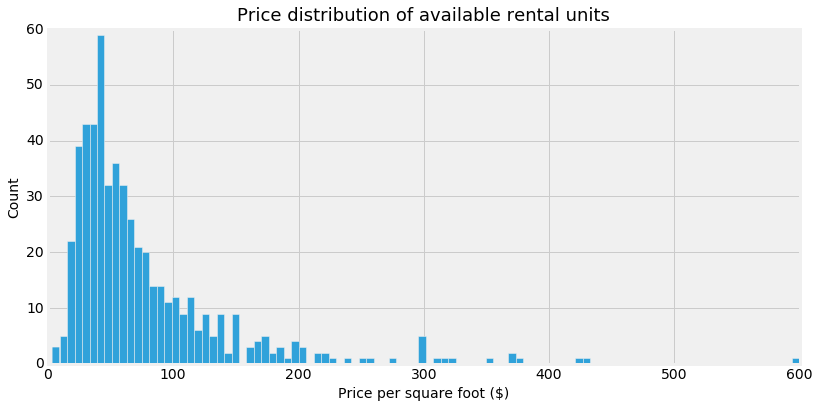

In [61]:
# Price distribution of available rental units

ax = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['Price_per_sf_per_year'].hist(figsize = (12, 6), bins = 100)
ax.tick_params(axis='both', labelsize = 14)
ax.set_title('Price distribution of available rental units', y = 1.01, fontsize = 18)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Price per square foot ($)', fontsize = 14)
plt.savefig('Price_distribution_rent_units.png');

In [26]:
rent_yelp_taxi['Price_per_sf_per_year'].describe()

count    554.000000
mean      75.529657
std       67.141885
min        3.340000
25%       35.140000
50%       55.000000
75%       90.000000
max      600.000000
Name: Price_per_sf_per_year, dtype: float64

In [60]:
rent_yelp_taxi[rent_yelp_taxi['Price_per_sf_per_year'] > 500]

Full_Street_address  SF_avail  Price_per_sf_per_year  \
278  147 Spring Street, New York, NY 10012      1800                  600.0   

                                             Prop_desc   Latitude  Longitude  \
278  ('Located between Wooster and West Broadway.  ...  40.724437 -74.001269   

         City  Zipcode                   Position             block_id  \
278  New York    10012  [-74.0012695, 40.7244374]  15000US360610049001   

         ...        Rate_min  Review_mean  Review_std  Review_max  Review_min  \
278      ...             3.5        355.7  286.991696         898          22   

     Sentiment_mean  Sentiment_std  Sentiment_max  Sentiment_min  \
278        0.257579       0.056347       0.373362       0.185547   

     dropoff_count  
278           4878  

[1 rows x 27 columns]

#### Comments:

Average rental prices in NYC should be in the region of about \$800 per square foot per year, with the highest prices in the region of about \$4,000. The price distribution is very much lower than the values reported in the [media](https://www.rebny.com/content/rebny/en/newsroom/research/REBNYRetailReport/Spring_2016_Manhattan_Retail_Report.html). Average prices on 34th street between 5th and 7th avenue is about \$890.

Prime units such as these are usually not listed publicly on the market, they are usually marketed exclusively by high end property management companies.

Nevertheless, while not ideal, the project can continue with the current set of rental units.

In [773]:
rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['SF_avail'].describe()

count      542.000000
mean      2739.662362
std       2825.287836
min        225.000000
25%       1000.000000
50%       1747.000000
75%       3200.000000
max      17785.000000
Name: SF_avail, dtype: float64

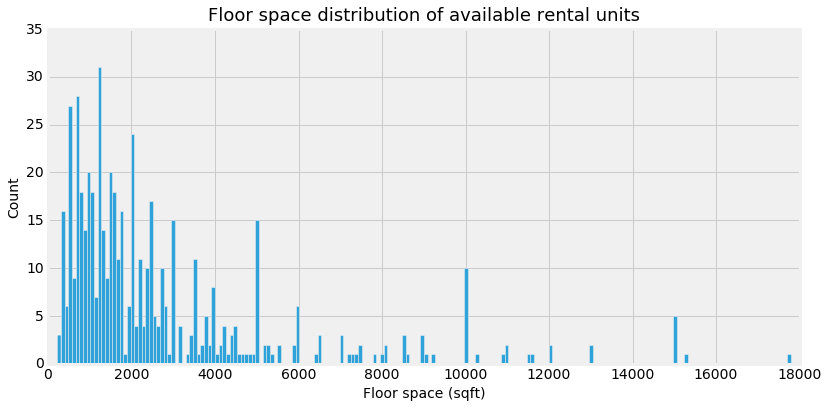

In [55]:
# Floor space distribution of available rental units (< 20,000)

ax = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['SF_avail'].hist(figsize = (12, 6), bins = 200)
ax.tick_params(axis='both', labelsize = 14)
ax.set_title('Floor space distribution of available rental units', y = 1.01, fontsize = 18)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Floor space (sqft)', fontsize = 14)
plt.savefig('Floor_space_distribution_rent_units.png');

#### Comments:

There were 10 listings which were over 20,000 sqft in the dataset in terms of available floor space. Most of these were listings for entire projects, with floor space and psf data entered as the largest and lowest respectively. The decision was to drop these entries as such potential market for extraordinarily large spaces is very small and summarized information for entire projects is unreliable.

Sidenote: From the histogram above, it also seem to indicate that listings tend to round floor spaces to whole numbers, as indicated by the spikes in round number floor spaces such as 5,000, 10,000 and 15,000.

In [81]:
price_size = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000][['Price_per_sf_per_year', 'SF_avail']]

scale = RobustScaler()

price_size = scale.fit_transform(price_size)
price_size = pd.DataFrame(price_size, columns = ['Price_per_sf_per_year', 'SF_avail'])

In [82]:
price_size.describe()

Price_per_sf_per_year    SF_avail
count             542.000000  542.000000
mean                0.387417    0.451210
std                 1.251108    1.284222
min                -0.965926   -0.691818
25%                -0.361111   -0.339545
50%                 0.000000    0.000000
75%                 0.638889    0.660455
max                10.083333    7.290000

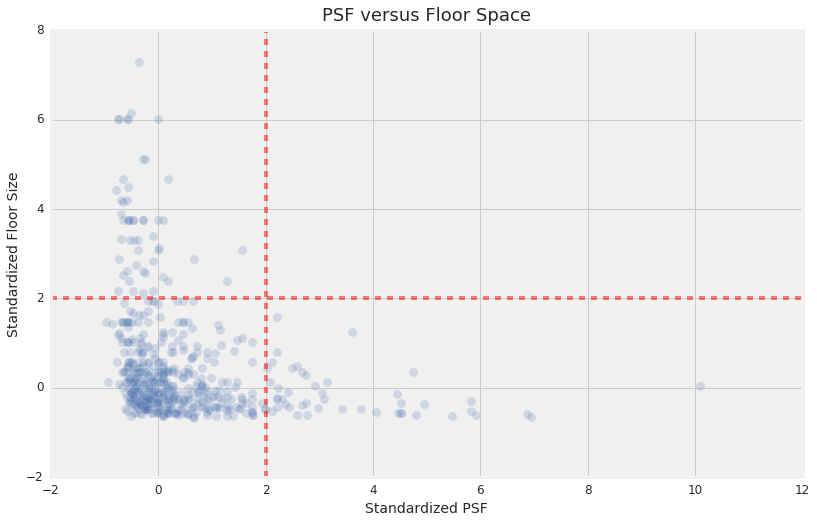

In [101]:
ax = price_size.plot.scatter('Price_per_sf_per_year', 'SF_avail', figsize = (12,8), s = 80, alpha  = 0.2)

ax.axvline(x = 2,  linestyle='--', color = 'r', alpha = 0.5)
ax.axhline(y = 2,  linestyle='--', color = 'r', alpha = 0.5)

ax.tick_params(axis = 'both', labelsize = 12)
ax.set_ylabel('Standardized Floor Size', fontsize = 14)
ax.set_xlabel('Standardized PSF', fontsize = 14)
ax.set_title('PSF versus Floor Space', y = 1.01, fontsize = 18)
plt.savefig('Scatter_psf_floor_space.png');

In [407]:
# Correlation of PSF witih floor space
price_size.corr()

Price_per_sf_per_year  SF_avail
Price_per_sf_per_year               1.000000 -0.264614
SF_avail                           -0.264614  1.000000

#### Comments:

All large units (> 2 standardized unit) has low prices (< 2) and all expensive units (> 2) have small sizes (< 2).

### Taxi EDA - Dropoff counts by the hour

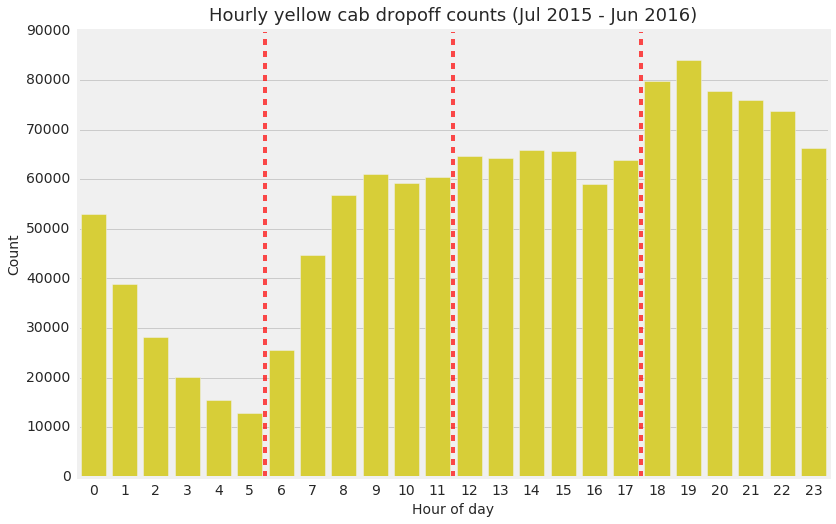

In [109]:
# Dropoff distribution across hour of day

plt.figure(figsize=(12,8))
ax = sns.countplot(x = 'dropoff_hour', data = taxi, color='#F2E51D')

# Potential bins for modelling later
ax.axvline(x = 5.5,  linestyle='--', color = 'r', alpha = 0.7)
ax.axvline(x = 11.5,  linestyle='--', color = 'r', alpha = 0.7)
ax.axvline(x = 17.5,  linestyle='--', color = 'r', alpha = 0.7)

ax.set_xlabel('Hour of day', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_title('Hourly yellow cab dropoff counts (Jul 2015 - Jun 2016)', y = 1.01, fontsize = 18)

plt.savefig('hourly_taxi_dropoff_count.png');

#### Comments:

Passenger dropoff counts plotted against the dropoff hour of the day showed that the time of the day can be broken down into 4 groups:

- Nightlife group
- Morning rush-hour group
- Tourists/Meeting group
- Evening rush-hour group

Binning into such groups could be useful to isolate rental locations for specific business needs such as restaurants, fashion or gyms.

### Taxi EDA - Dropoff count by city blocks

In [133]:
# Loading in a dataframe of dropoff counts by city blocks
# Created separately

with open('/Users/peidacai/Desktop/taxi_dropoff_count_df.pkl', 'r') as f:
    df2 = pickle.load(f)

In [135]:
df2.head(2)

dropoff_block  count
0  15000US360050002001      7
1  15000US360050002002      9

In [778]:
# Using folium to create the html file

# Defining path for geojson cityblock overlay for NYC city block boundaries
nyc_block_geo = '/Users/peidacai/Desktop/rdf.json'

# Initializing starting center position and zoom_state
m = folium.Map(location=[40.748660, -73.985741], zoom_start=13)


# Add a geojson layer of the zipcode from geojson file containing NYC zipcode polygons
m.choropleth(geo_path = nyc_block_geo,
             
             #Adding choropleth layer
             data = df2,
             columns = ['dropoff_block', 'count'],
             
             key_on = 'feature.properties.geo_id',
             threshold_scale=[0,500,3000,8000,15000,30000],
             fill_color = 'YlGnBu',
             fill_opacity = 0.6,
             line_opacity = 0.1,
             legend_name = 'Taxi dropoff counts',
             reset = True
              )

# Displaying inline
m


#### Comments:

I wanted to use NYC city block data, however, due to its high granularity nature, it is computationally inefficient. Therefore, this geojson file was chosen instead, as a compromise between cityblock and zipcodes.

Beside the transport hubs such as Penn and Grand Central Stations and the airports, the other highest dropoff places were on the west, near Jacob Javits Convention Center as well as Central Park.

There are smaller pockets of high dropoff blocks in downtown, around 23rd street and Union Square.

In [153]:
price_drop = rent_yelp_taxi[['Price_per_sf_per_year', 'dropoff_count', 'SF_avail']]

scale = MinMaxScaler()

price_drop = scale.fit_transform(price_drop)
price_drop = pd.DataFrame(price_drop, columns = ['Price_per_sf_per_year', 'dropoff_count', 'SF_avail'])

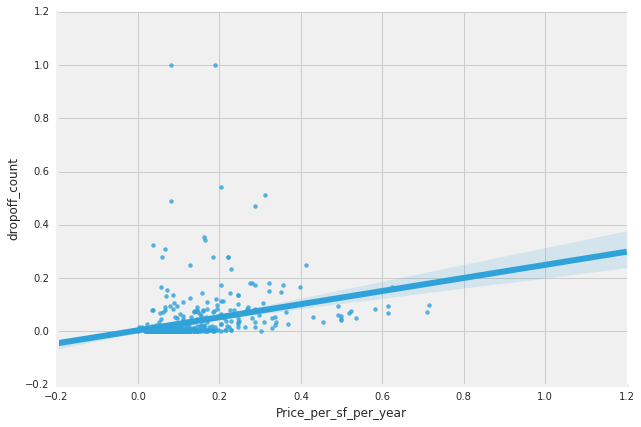

In [414]:
# PSF versus dropcount

ax = sns.lmplot(x = 'Price_per_sf_per_year', y = 'dropoff_count', data=price_drop, 
                size=6, aspect=1.5)
#ax.axvline(x = 2,  linestyle='--', color = 'r', alpha = 0.5)
#ax.axhline(y = 2,  linestyle='--', color = 'r', alpha = 0.5)

#ax.set_ylim(-0.01, 0.5)
#ax.set_xlim(-0.01, 0.5)

#ax.tick_params(axis = 'both', labelsize = 12)
#ax.set_ylabel('Standardized Taxi Dropoff', fontsize = 14)
#ax.set_xlabel('Standardized PSF', fontsize = 14)
#ax.set_title('PSF versus Taxi_dropoff', y = 1.01, fontsize = 18)
plt.savefig('Scatter_psf_dropoff.png');

#### Comments:

Except for some of the highest dropoff locations, mentioned above such as the airports, land transport hubs (Penn station and Grand Central) and Central Park, there was a gentle linear relationship between prices and taxi dropoff count, further confirming our hypothesis.

### Yelp Data EDA: Metrics for top 10 nearest businesses

![top_10_businesses](top_10_nearest_businesses_yelp.png)

For each available rental location, social media data is obtained from webscraping Yelp for top 10 nearest businesses for the following metrics:

    1. "$" metric: 
    
        An indication of the type of market in the vincity, i.e. spending power of target segment of businesses in the area

    2. Review ratings: 
    
        While this depends solely on the performance of each individual business, it provides an indication of the acceptability of businesses in the geographical location. It could be a business decision to locate themselves within high performing neighbors or otherwise. A classic big fish in small pond versus small fish in big pond consideration. Another consideration could be locating near complementary businesses, for example a dessert place near high performing restaurant areas to capture after-meal crowds.

    3. Average number of reviews:
    
        This is an indication of the popularity of the geographical location, which is an indication of the potential reach of a geographical location.

In [426]:
# Creating a label of 1 for units with psf above mean and 0 otherwise

rent_yelp_taxi['PSF_Above_mean'] = rent_yelp_taxi['Price_per_sf_per_year'].apply(lambda x: 1 if x > rent_yelp_taxi['Price_per_sf_per_year'].mean() else 0)

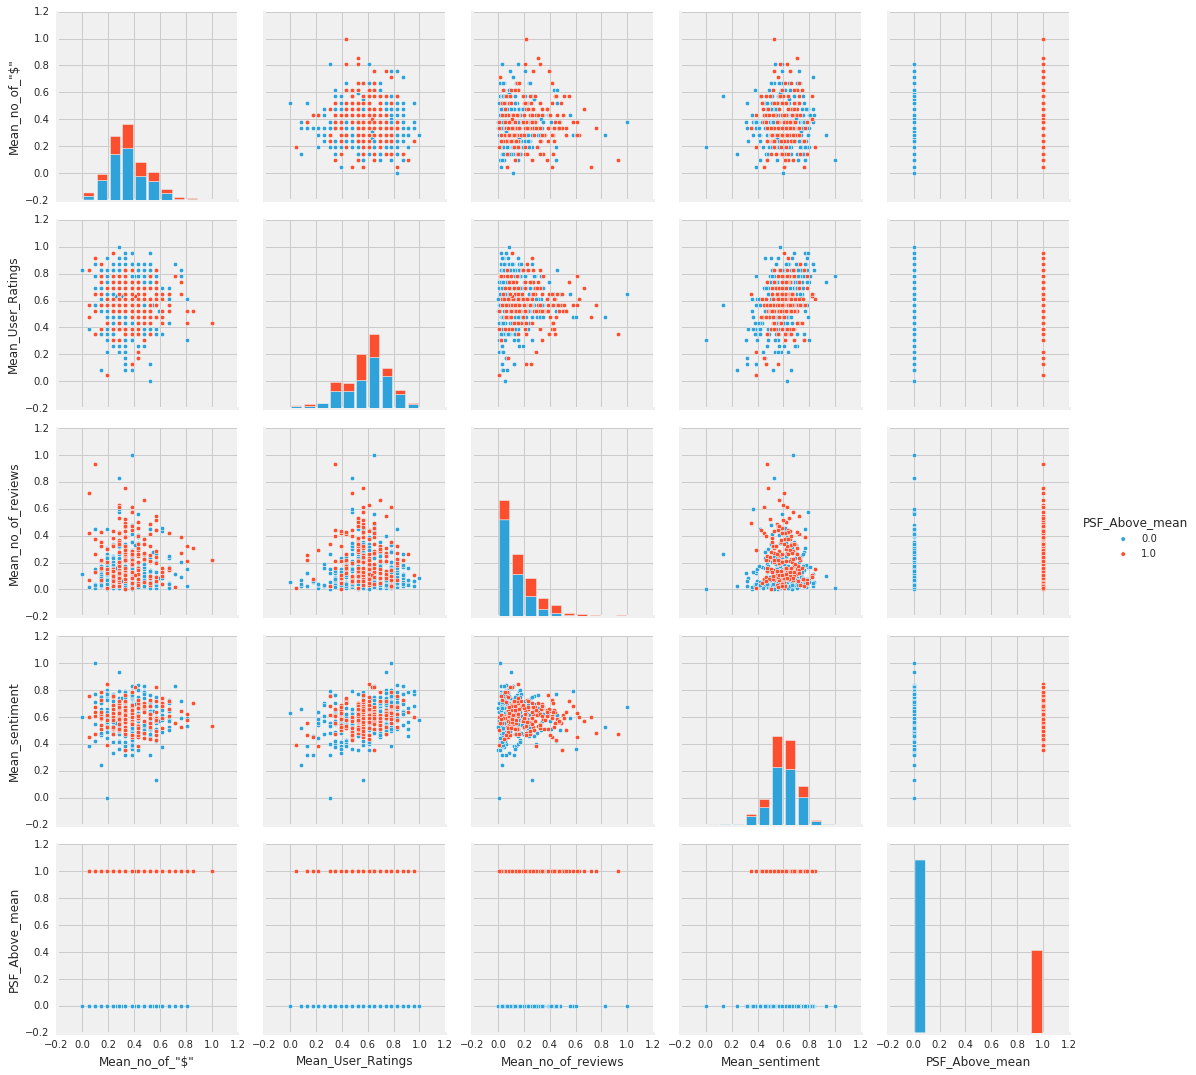

In [679]:
yelp = rent_yelp_taxi[['Cost_mean', 
                       'Rate_mean', 
                       'Review_mean',
                       'Sentiment_mean',
                       'PSF_Above_mean']]

yelp_scale = pd.DataFrame(MinMaxScaler().fit_transform(yelp), columns= ['Mean_no_of_"$"', 
                                                           'Mean_User_Ratings',
                                                           'Mean_no_of_reviews',
                                                           'Mean_sentiment',
                                                           'PSF_Above_mean'])
sns.pairplot(yelp_scale, size = 3, aspect = 1, hue = 'PSF_Above_mean')

#### Comments:

The cost metric (number of '$') and user rating didn't seem to have meaningful predictive abilities. However, it seemed that number of reviews had some meaningful differences.

In [681]:
# Pivoting yelp data to demonstrate differences in mean between yelp metrics

yelp_piv = pd.pivot_table(yelp_scale, ['Mean_no_of_"$"',
                                       'Mean_User_Ratings',
                                       'Mean_no_of_reviews',
                                       'Mean_sentiment'], 
                          index = 'PSF_Above_mean')

yelp_piv.reset_index(inplace = True, drop = True)
yelp_piv.T

0         1
Mean_User_Ratings   0.604016  0.569068
Mean_no_of_"$"      0.355845  0.379456
Mean_no_of_reviews  0.126388  0.238343
Mean_sentiment      0.599140  0.601644

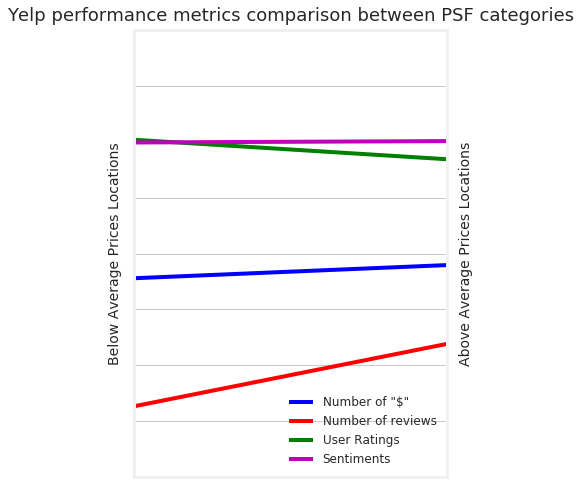

In [691]:
# Plotting yelp performance metrics comparison between PSf categories

x = [0,1]

a = yelp_piv.loc[:, 'Mean_no_of_"$"'].T.values

b = yelp_piv.loc[:, 'Mean_no_of_reviews'].T.values

c = yelp_piv.loc[:, 'Mean_User_Ratings'].T.values

d = yelp_piv.loc[:, 'Mean_sentiment'].T.values

fig, ax = plt.subplots(figsize = (5,8))
ax2 = ax.twinx()
ax.set_axis_bgcolor('white')
ax.grid(which='major',axis = 'x')
ax2.grid(which='major',axis = 'x')

line_a = plt.plot(x, a, 'xb-', label = 'Number of "$"')
line_b = plt.plot(x, b, 'xr-', label = 'Number of reviews')
line_c = plt.plot(x, c, 'xg-', label = 'User Ratings')
line_d = plt.plot(x, d, 'xm-', label = 'Sentiments')

plt.legend(loc='lower right', fontsize = 12)

ax.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_yticklabels([])

ax.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)

ax.set_ylabel('Below Average Prices Locations', fontsize = 14)
ax2.set_ylabel('Above Average Prices Locations', fontsize = 14)


ax.set_title('Yelp performance metrics comparison between PSF categories', y = 1.01, fontsize = 18)
plt.savefig('yelp_performance_compare.png');

#### Comments:

This chart compare yelp metrics between rental units with PSF below or equal to mean (left axis) and units above mean PSF (right axis). Each line represents a yelp performance metric. If there were significant differences between the two PSF categories, we should be seeing lines with high gradients.

The metric which showed highest discriminating ability between the categories was "Number of reviews" (or popularity of a location). Rental locations with prices above the mean PSF had higher number of yelp reviews.

Interestingly, mean user ratings for businesses in "expensive" areas were lower than businesses in "cheaper" areas, evident from the downward sloping green line, though not by much.

Expensive locations didn't correlate with "Number of '$'". Businesses targeting higher-spending power consumers did not neccesarily locate themselves in expensive rental locations.

Finally, sentiment analyses didn't offer much in discriminating ability, may consider to drop this feature when modelling to improve performance.

## Combined analyses

In [458]:
rev_taxi_psf = rent_yelp_taxi[['Review_mean', 'dropoff_count', 'PSF_Above_mean']]

rev_taxi_psf = pd.DataFrame(RobustScaler().fit_transform(rev_taxi_psf), columns = ['Review_mean', 'dropoff_count', 'PSF_Above_mean'])

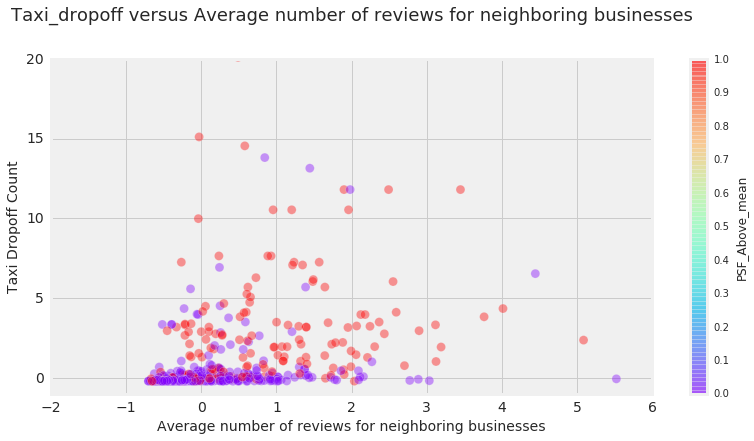

In [777]:
ax = rev_taxi_psf.plot.scatter('Review_mean', 'dropoff_count', c = 'PSF_Above_mean', 
                          cmap = 'rainbow', s = 80, figsize = (12,6), alpha = 0.4,
                          sharex = False)
ax.set_ylim(-1, 20)

ax.set_xlabel('Average number of reviews for neighboring businesses', fontsize = 14)
ax.set_ylabel('Taxi Dropoff Count', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 14)

ax.set_title('Taxi_dropoff versus Average number of reviews for neighboring businesses', y = 1.1, fontsize = 18)
plt.savefig('taxi_review_count_psf.png');

#### Comments:

In line with the earlier analyses, higher taxi dropoffs and higher number of yelp reviews in the area did seem to point towards more above average PSF locations.

# Modelling

## Approach

To test the hypothesis, the following approach to modeling will be adopted:

1. Fix random state
2. Specify a fix number of different modeling algorithms with a fixed number of scaling algorithms
3. Compare cross_val_scores of all models (default settings) for the following sets of features:

    a. Floor space available, zipcodes
    b. Floor space available, zipcodes, taxi dropoff count
    c. Floor space available, zipcodes, taxi dropoff count and Yelp review data
4. Both classifier and regressors will be created for all combinations of models and scalers

## Modeling with rental data only

In [379]:
zip_dum = pd.get_dummies(rent_yelp_taxi['Zipcode'], prefix='Zip_', drop_first=True)

In [380]:
X = pd.concat([rent_yelp_taxi['SF_avail'], zip_dum], axis = 1)

In [698]:
# Creating output for classifier algorithm
# 1 for above mean
# 0 otherwise

y = rent_yelp_taxi['Price_per_sf_per_year'].apply(lambda x: 1 if x > rent_yelp_taxi['Price_per_sf_per_year'].mean() else 0)
y.value_counts()

0    367
1    175
Name: Price_per_sf_per_year, dtype: int64

In [699]:
# Base line accuracy
base_line = round(y.value_counts()[0]/float(y.shape[0]), 3)
print base_line

0.677


In [383]:
X = X.astype(float)

In [384]:
# Defining a fixed random state
rand = 44

In [385]:
# Classifier models

rf = RandomForestClassifier(random_state=rand)
et = ExtraTreesClassifier(random_state=rand)
ada = AdaBoostClassifier(random_state=rand)
gb = GradientBoostingClassifier(random_state=rand)
lr = LogisticRegression(random_state=rand)
nb = GaussianNB()
knn = KNeighborsClassifier()
svc = SVC(random_state=rand)

In [386]:
# Regressors models

rfr = RandomForestRegressor(random_state=rand)
etr = ExtraTreesRegressor(random_state=rand)
adar = AdaBoostRegressor(random_state=rand)
gbr = GradientBoostingRegressor(random_state=rand)
linr = LinearRegression()
knnr = KNeighborsRegressor()
svr = SVR()

In [387]:
# List of different classifier models
models = [rf, et, ada, gb, lr, nb, knn, svc]

In [388]:
# List of different regressors models
model_reg = [rfr, etr, adar, gbr, linr, knnr, svr]

In [389]:
stand_scale = StandardScaler()
norm = Normalizer()
rob_scale = RobustScaler()
minmax_scale = MinMaxScaler()

In [390]:
# List of different scaling methods
scales = [stand_scale, norm, rob_scale, minmax_scale]

In [391]:
# Function to return name of ML model and/or scaling method

def return_name(algo):
    return str(algo).split('(')[0]

In [392]:
# Function to create a pipeline of scaler and model for classifiers
# Conduct cross-validation of each model
# Returns a dataframe of model, scaler and performance
# Chosen performance metric was "accuracy"

def models_pipeline(models, scales, X, y, folds):

    model_list = []
    scale_list = []
    acc_list = []
    std_list = []

    for model in models:
        for scale in scales:
            clf = make_pipeline(scale, model)
            model_list.append(return_name(model))
            scale_list.append(return_name(scale))
            scores = cross_val_score(clf, X, y, scoring = 'accuracy', cv = folds, n_jobs=-1)
            acc_list.append(round(scores.mean(), 3))
            std_list.append(round(scores.std(), 3))

    df = pd.DataFrame([model_list, scale_list, acc_list, std_list])
    df = df.T.sort_values(2, ascending = False)
    df.columns = ['Model', 'Scaler', 'Accuracy', 'Stdev']
    return df

In [395]:
# Function to create a pipeline of scaler and model for regressors
# Conduct cross-validation of each model
# Returns a dataframe of model, scaler and performance
# Chosen performance metric was "MSE", but returns "RMSE"

def models_reg_pipeline(models, scales, X, y, folds):

    model_list = []
    scale_list = []
    acc_list = []
    std_list = []

    for model in models:
        for scale in scales:
            clf = make_pipeline(scale, model)
            model_list.append(return_name(model))
            scale_list.append(return_name(scale))
            scores = cross_val_score(clf, X, y, scoring = 'neg_mean_squared_error', cv = folds, n_jobs=-1)
            acc_list.append((round(np.sqrt(abs(scores.mean())), 3)))
            std_list.append(round(np.sqrt(abs(scores).std()), 3))

    df = pd.DataFrame([model_list, scale_list, acc_list, std_list])
    df = df.T.sort_values(2)
    df.columns = ['Model', 'Scaler', 'RMSE', 'Stdev']
    return df

In [364]:
# Classifier models
# Creating dataframe of model, scalers and performance for rental data only
rent_model = models_pipeline(models, scales, X, y, 10)

In [365]:
rent_model.head(10)

Model          Scaler Accuracy  Stdev
9           AdaBoostClassifier      Normalizer    0.833  0.051
15  GradientBoostingClassifier    MinMaxScaler    0.832  0.046
12  GradientBoostingClassifier  StandardScaler    0.831  0.045
14  GradientBoostingClassifier    RobustScaler    0.831  0.045
18          LogisticRegression    RobustScaler    0.827  0.045
11          AdaBoostClassifier    MinMaxScaler    0.823  0.033
8           AdaBoostClassifier  StandardScaler    0.821  0.032
10          AdaBoostClassifier    RobustScaler    0.821  0.032
28                         SVC  StandardScaler     0.82  0.052
19          LogisticRegression    MinMaxScaler    0.814  0.046

In [396]:
# Regressor models
# Creating dataframe of model, scalers and performance for rental data only

rent_reg_model = models_reg_pipeline(model_reg, scales, X, rent_yelp_taxi['Price_per_sf_per_year'], 10)
rent_reg_model.head(10)

Model          Scaler    RMSE   Stdev
15  GradientBoostingRegressor    MinMaxScaler  53.784  46.206
14  GradientBoostingRegressor    RobustScaler   53.79  46.208
12  GradientBoostingRegressor  StandardScaler   53.79  46.208
21        KNeighborsRegressor      Normalizer  55.658  36.578
22        KNeighborsRegressor    RobustScaler  56.832  42.855
13  GradientBoostingRegressor      Normalizer  57.364  43.457
3       RandomForestRegressor    MinMaxScaler  57.788  45.126
2       RandomForestRegressor    RobustScaler  57.805   45.13
0       RandomForestRegressor  StandardScaler  57.807  45.128
20        KNeighborsRegressor  StandardScaler  58.099  41.669

#### Comments:

Regressor modeling with rental data only resulted in RMSE of $53.78

## Modelling with rental and yelp business data

In [397]:
X = pd.concat([rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                          'Rate_mean', 'Rate_std', 'Review_mean', 
                          'Review_std', 'Sentiment_mean', 'Sentiment_std']], zip_dum], axis = 1)

In [398]:
X.shape

(542, 133)

In [399]:
X = X.astype(float)

In [314]:
rent_yelp_model = models_pipeline(models, scales, X, y, 10)

In [315]:
rent_yelp_model.head(10)

Model          Scaler Accuracy  Stdev
28                         SVC  StandardScaler    0.821  0.046
19          LogisticRegression    MinMaxScaler    0.815   0.05
4         ExtraTreesClassifier  StandardScaler    0.808  0.043
6         ExtraTreesClassifier    RobustScaler    0.808  0.043
7         ExtraTreesClassifier    MinMaxScaler    0.808  0.043
13  GradientBoostingClassifier      Normalizer    0.806  0.042
18          LogisticRegression    RobustScaler    0.804  0.064
15  GradientBoostingClassifier    MinMaxScaler    0.784  0.045
9           AdaBoostClassifier      Normalizer    0.784  0.042
12  GradientBoostingClassifier  StandardScaler    0.782  0.044

In [316]:
rent_yelp_model.head(10)['Accuracy'].mean()

0.80199999999999994

In [400]:
rent_yelp_reg_model = models_reg_pipeline(model_reg, scales, X, rent_yelp_taxi['Price_per_sf_per_year'], 10)
rent_yelp_reg_model.head(10)

Model          Scaler    RMSE   Stdev
12  GradientBoostingRegressor  StandardScaler  49.845  37.606
15  GradientBoostingRegressor    MinMaxScaler  49.867  37.619
14  GradientBoostingRegressor    RobustScaler  49.868  37.619
4         ExtraTreesRegressor  StandardScaler  50.217  44.741
6         ExtraTreesRegressor    RobustScaler  50.217  44.741
7         ExtraTreesRegressor    MinMaxScaler  50.217  44.741
13  GradientBoostingRegressor      Normalizer  51.423  39.532
1       RandomForestRegressor      Normalizer  53.873  37.587
5         ExtraTreesRegressor      Normalizer  53.889  38.393
0       RandomForestRegressor  StandardScaler  55.518  40.489

# Adding in taxi data for modelling

In [401]:
X_taxi = pd.concat([X, rent_yelp_taxi['dropoff_count']], axis = 1)

In [402]:
X_taxi.head()

SF_avail  Cost_mean  Cost_std  Rate_mean  Rate_std  Review_mean  \
0    3840.0        2.6  0.966092       4.30  0.349603        318.9   
1    4200.0        2.0  0.666667       4.05  0.368932        255.7   
2    1669.0        1.6  0.699206       4.05  0.497214         92.3   
3    3500.0        1.9  0.567646       3.95  0.497214        182.8   
4    1163.0        1.7  0.674949       4.40  0.316228        314.1   

   Review_std  Sentiment_mean  Sentiment_std  Zip__10002      ...        \
0  350.267025        0.211583       0.060270         0.0      ...         
1  222.290126        0.200312       0.063121         0.0      ...         
2   57.391540        0.240143       0.053765         0.0      ...         
3  168.009127        0.215797       0.051486         0.0      ...         
4  416.860342        0.236805       0.046646         0.0      ...         

   Zip__11426  Zip__11427  Zip__11429  Zip__11432  Zip__11433  Zip__11434  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Zip__11435  Zip__11436  Zip__11694  dropoff_count  
0         0.0         0.0         0.0           1681  
1         0.0         0.0         0.0            794  
2         0.0         0.0         0.0             95  
3         0.0         0.0         0.0           1386  
4         0.0         0.0         0.0            973  

[5 rows x 134 columns]

## Modelling with taxi drop-off data

In [319]:
rent_yelp_taxi_model = models_pipeline(models, scales, X_taxi, y, 10)

In [320]:
rent_yelp_taxi_model.head(10)

Model          Scaler Accuracy  Stdev
13  GradientBoostingClassifier      Normalizer    0.845  0.047
5         ExtraTreesClassifier      Normalizer    0.827  0.048
17          LogisticRegression      Normalizer    0.821  0.051
28                         SVC  StandardScaler    0.818  0.046
19          LogisticRegression    MinMaxScaler    0.816  0.042
4         ExtraTreesClassifier  StandardScaler     0.81  0.041
6         ExtraTreesClassifier    RobustScaler     0.81  0.041
7         ExtraTreesClassifier    MinMaxScaler     0.81  0.041
25        KNeighborsClassifier      Normalizer     0.81   0.06
14  GradientBoostingClassifier    RobustScaler    0.806  0.047

In [321]:
rent_yelp_taxi_model.head(10)['Accuracy'].mean()

0.81730000000000014

In [403]:
rent_yelp_taxi_reg_model = models_reg_pipeline(model_reg, scales, X_taxi, rent_yelp_taxi['Price_per_sf_per_year'], 10)
rent_yelp_taxi_reg_model.head(10)

Model          Scaler    RMSE   Stdev
4         ExtraTreesRegressor  StandardScaler  49.507  44.514
6         ExtraTreesRegressor    RobustScaler  49.507  44.514
7         ExtraTreesRegressor    MinMaxScaler  49.507  44.514
15  GradientBoostingRegressor    MinMaxScaler  50.159  44.256
14  GradientBoostingRegressor    RobustScaler  50.166  44.254
12  GradientBoostingRegressor  StandardScaler  50.166  44.253
1       RandomForestRegressor      Normalizer   50.73  41.843
3       RandomForestRegressor    MinMaxScaler  51.173  41.348
13  GradientBoostingRegressor      Normalizer   51.18  42.945
0       RandomForestRegressor  StandardScaler   51.24   41.29

In [696]:
rent_model.iloc[0, 2]

0.833

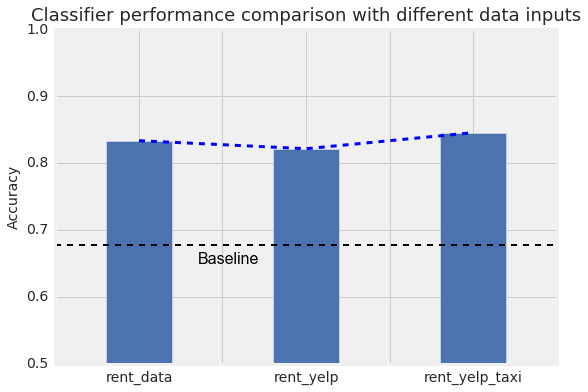

In [776]:
# Comparing classifier performances with different input data

x = [0,1,2]

a = [rent_model.iloc[0, 2], rent_yelp_model.iloc[0,2], rent_yelp_taxi_model.iloc[0,2]]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, a, align = 'center', width = 0.4)
plt.plot(x, a, 'xb--', linewidth = 3)

ax.hlines(y = base_line, xmin = -0.5, xmax = 2.5, colors = 'k', linestyles='dashed', label='baseline', linewidth = 2)
plt.text(0.35,0.65,'Baseline', fontsize = 16, color = 'k')
ax.set_ylim(0.5, 1)
ax.set_xticklabels(['', 'rent_data', '', 'rent_yelp', '', 'rent_yelp_taxi', ''])
ax.set_title('Classifier performance comparison with different data inputs', y = 1.01, fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
plt.savefig('classifier_compare.png');

#### Comments:

Although a regression model should be the output of this project, classifiers were compared following on the EDA comparison of above and below mean Price per square foot. Future predictive modeling will be conducted using only regressions instead.

Firstly, with a base model of using only floor space and zipcodes as features, accuracy rates improved over baseline coin-flip to 83.3%. When yelp data was introduced, accuracy dropped a little (82.1%), but improved once taxi data was included as well (84.5%).

These models were created using only default parameters and have not been tuned yet. Performance should improve with further tuning, feature selection and feature engineering such as binning.

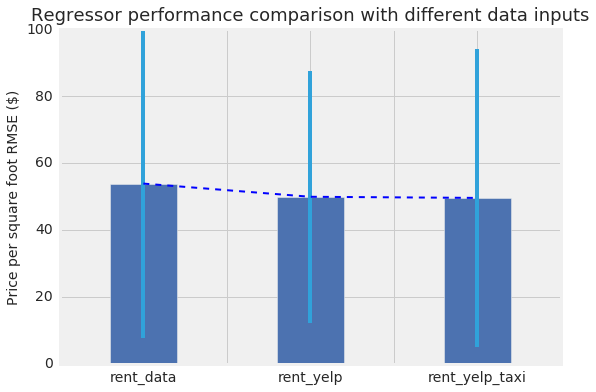

In [775]:
# Comparing regressor performances with different input data

x = [0,1,2]

y = [rent_reg_model.iloc[0, 2], rent_yelp_reg_model.iloc[0,2], rent_yelp_taxi_reg_model.iloc[0,2]]
err = [rent_reg_model.iloc[0, 3], rent_yelp_reg_model.iloc[0,3], rent_yelp_taxi_reg_model.iloc[0,3]]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', '', 'rent_yelp', '', 'rent_yelp_taxi', ''])
ax.set_title('Regressor performance comparison with different data inputs', y = 1.01, fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('Price per square foot RMSE ($)', fontsize = 14)
plt.savefig('regressor_compare.png');

#### Comments:

Predictive ability improved with additional dataset under regression modeling, with both Yelp and taxi data, RMSE dropped by about \$4 per sqft per year. For an average floor space of this dataset of 2,740 sqft, this translates to savings of \$10,960 per year.

However, standard deviation of RMSE also increased with more dataset. More feature engineering and parameter tuning would be conducted to improve these conditions.

# Conclusion and way ahead

Initial modeling had demonstrated that both Yelp and Taxi data could improve on the predictive performances for retail rental the next steps would be mainly 2 folds:

1. Further feature engineering such as:

    - Binning of data such as taxi dropoff hour
    - Feature selection to remove poorly performing features, possibly such as Yelp Sentiments

2. Model tuning

    - Selected models will be Gridsearch for optimal parameters
    - Ensembling models